# Multi-Armed Bandits

In [52]:
from typing import Union, List, Dict
import matplotlib.pyplot as plt
import numpy as np

In the setup below, we assume that we start at $t=0$ and thus there is no previous action or current reward. We also assume that all arms must be pulled at least **once** before executing the entire algorithm - this is known as $warm\_up$. Depending on the current needs, we can adapt the code - an alternative setup is considered in the `.py` files.

In [53]:
class EpsilonGreedy:

    """
    Initialise epsilon-greedy agent.
    - This agent returns an action between 0 and 'number_of_arms'.
    - It does so with probability `(1-epsilon)` it chooses the action with the highest estimated value, while
    with probability `epsilon`, it samples an action uniformly at random.
    """
    def __init__(self, name: str, number_of_arms: int, epsilon=Union[float, callable]):
        self.name = name
        self._number_of_arms = number_of_arms
        self._epsilon = epsilon
        self.reset()

    """
    Execute Epsilon-Greedy agent's next action and update Epsilon Greedy's action-state values.
    """
    def step(self, reward_dist: Dict[int, Union[float, int]]) -> int:
        # All actions must be selected at least once before Epsilon-Greedy is applied
        if np.any(self.N_t == 0):
            # Select non-explored action
            action = np.random.choice(np.where(self.N_t == 0)[0])
            # Obtain stochastic reward from chosen action
            reward = np.random.choice(reward_dist[action])
            # Update action count for previous action
            self.N_t[action] += 1
            # Use iterative form of Q_t(a)
            self.Q_t[action] += (1 / self.N_t[action]) * (reward - self.Q_t[action])
        else:
            # Check if epsilon is scalar or callable
            new_epsilon = self._epsilon if np.isscalar(self._epsilon) else self._epsilon(self.t)
            # A_t(a) is the 'action' chosen at time step 't'
            action = np.random.choice(np.where(self.Q_t == np.max(self.Q_t))[0]) if np.random.uniform() < 1 - new_epsilon else np.random.randint(0, self.Q_t.shape[0])
            # Obtain stochastic reward from chosen action
            reward = np.random.choice(reward_dist[action])
            # Update action count for previous action
            self.N_t[action] += 1
            # Use iterative form of Q_t(a)
            self.Q_t[action] += (reward - self.Q_t[action]) / self.N_t[action]
        # Update time step counter
        self.t += 1
        # Update stochastic rewards
        self.rewards = np.append(self.rewards, reward)
        # Update actions
        self.actions = np.append(self.actions, action)

    """
    Reset Epsilon Greedy agent.
    """
    def reset(self):
        # Q_t(a) is the estimated value of action ‘a’ at time step ‘t’
        self.Q_t = np.zeros(self._number_of_arms)
        # N_t(a) is the number of times that action ‘a’ has been selected, prior to time ‘t’
        self.N_t = np.zeros(self._number_of_arms)
        # Set time step counter
        self.t = 0
        # Set stochastic rewards
        self.rewards = np.array([])
        # Set actions
        self.actions = np.array([])

In [54]:
class UCB:
    
    """
    Initialise UCB agent. 
    - This agent returns an action between 0 and 'number_of_arms'.
    - This agent uses uncertainty in the action-value estimates for balancing exploration and exploitation.
    """
    def __init__(self, name: str, number_of_arms: int, bonus_multiplier: float):
        self._number_of_arms = number_of_arms
        self._bonus_multiplier = bonus_multiplier
        self.name = name
        self.reset()

    """
    Execute UCB agent's next action and update UCB's action-state values.
    """
    def step(self, reward_dist: Dict[int, Union[float, int]]) -> int:
        # All actions must be selected at least once before UCB is applied
        if np.any(self.N_t == 0):
            # Select non-explored action
            action = np.random.choice(np.where(self.N_t == 0)[0])
            # Obtain stochastic reward from chosen action
            reward = np.random.choice(reward_dist[action])
            # Update action count for previous action
            self.N_t[action] += 1
            # Use iterative form of Q_t(a)
            self.Q_t[action] += (1 / self.N_t[action]) * (reward - self.Q_t[action])
        else:
            # Calculate expected reward values
            reward_values = self.Q_t + self._bonus_multiplier * np.sqrt(np.log(self.t) / self.N_t)
            # A_t(a) is the 'action' chosen at time step 't'
            action = np.random.choice(np.where(reward_values == np.max(reward_values))[0])
            # Obtain stochastic reward from chosen action
            reward = np.random.choice(reward_dist[action])
            # Update action count for previous action
            self.N_t[action] += 1
            # Use iterative form of Q_t(a)|
            self.Q_t[action] += (1 / self.N_t[action]) * (reward - self.Q_t[action])
        # Update time step counter
        self.t += 1
        # Update stochastic rewards
        self.rewards = np.append(self.rewards, reward)
        # Update actions
        self.actions = np.append(self.actions, action)

    """
    Reset UCB agent.
    """
    def reset(self):
        # Q_t(a) is the estimated value of action ‘a’ at time step ‘t’
        self.Q_t = np.zeros(self._number_of_arms)
        # N_t(a) is the number of times that action ‘a’ has been selected, prior to time ‘t’
        self.N_t = np.zeros(self._number_of_arms)
        # Set time step counter
        self.t = 0
        # Set stochastic rewards
        self.rewards = np.array([])
        # Set actions
        self.actions = np.array([])

In [55]:
# Define Greedy Algorithm
greedy_alg = EpsilonGreedy(name="Greedy", 
                           number_of_arms=10, 
                           epsilon=0)
# Define Epsilon-Greedy Algorithm
eps_greedy_alg = EpsilonGreedy(name="Epsilon-Greedy", 
                           number_of_arms=10, 
                           epsilon=lambda t: 1/np.sqrt(t))
# Define UCB Algorithm
ucb_alg = UCB(name="UCB", 
              number_of_arms=10, 
              bonus_multiplier=2)

In [56]:
def run_multi_armed_bandits(algs: List, true_reward_dist: Dict[int, Union[int, float]], num_iter: int):
    # Loop over number of iterations
    for i in range(num_iter):
        # Loop over each algorithm
        for j in range(len(algs)):
            # Execute remaining steps of algorithm
            algs[j].step(reward_dist=true_reward_dist)
    # Plot expected rewards
    plt.plot(np.cumsum(greedy_alg.rewards)/np.arange(1, num_iter+1, 1), label="Greedy")
    plt.plot(np.cumsum(eps_greedy_alg.rewards)/np.arange(1, num_iter+1, 1), label="Epsilon Greedy")
    plt.plot(np.cumsum(ucb_alg.rewards)/np.arange(1, num_iter+1, 1), label="UCB")
    plt.legend(loc="best")
    plt.title("Expected Rewards")
    plt.show()
    # Plot reward estimate values
    categories = [f"Arm {k+1}" for k in range(algs[0]._number_of_arms)]
    bar_width = 0.2 
    index = np.arange(len(categories)) 
    plt.bar(index - bar_width, greedy_alg.Q_t, bar_width, label='Greedy')
    plt.bar(index, eps_greedy_alg.Q_t, bar_width, label='Epsilon Greedy')
    plt.bar(index + bar_width, ucb_alg.Q_t, bar_width, label='UCB')
    plt.xlabel('Arms')
    plt.ylabel(r'$Q_{t}\left(a\right)$')
    plt.title('Reward Estimate Value')
    plt.xticks(index, categories)
    plt.legend(loc="best")
    plt.show()
    # Plot distribution of pulled arms
    categories = [f"Arm {k+1}" for k in range(algs[0]._number_of_arms)]
    bar_width = 0.2 
    index = np.arange(len(categories)) 
    plt.bar(index - bar_width, greedy_alg.N_t, bar_width, label='Greedy')
    plt.bar(index, eps_greedy_alg.N_t, bar_width, label='Epsilon Greedy')
    plt.bar(index + bar_width, ucb_alg.N_t, bar_width, label='UCB')
    plt.xlabel('Arms')
    plt.ylabel(r'$N_{t}\left(a\right)$')
    plt.title('Number of times each arm has been pulled')
    plt.xticks(index, categories)
    plt.legend(loc="best")
    plt.show()
    # Plot distribution of reward estimate to true 
    fig, ax = plt.subplots(nrows=len(algs), ncols=algs[0]._number_of_arms, figsize=(20,20))
    for algorithm_index, alg in enumerate(algs):
        for arm in range(algs[0]._number_of_arms):
            arm_rewards = alg.rewards[np.where(alg.actions==arm)[0]]
            ax[algorithm_index, arm].hist(true_reward_dist[arm], bins=int(1+np.log2(1000)), alpha=0.5, color="blue", label='True Reward')
            ax[algorithm_index, arm].set_title(f'{alg.name} - Arm {arm + 1}')
            ax[algorithm_index, arm].set_xlabel('Value')
            ax[algorithm_index, arm].set_ylabel('Frequency')
            ax[algorithm_index, arm].set_yticks([]) 
            ax[algorithm_index, arm].legend(loc="best")
    # Show the subplots
    plt.show()
    # Plot action taken on each iteration
    plt.plot(np.arange(1, num_iter+1, 1), [action+1 for action in greedy_alg.actions], label='Greedy')
    plt.plot(np.arange(1, num_iter+1, 1), [action+1 for action in eps_greedy_alg.actions], label='Epsilon-Greedy')
    plt.plot(np.arange(1, num_iter+1, 1), [action+1 for action in ucb_alg.actions], label='UCB')
    plt.yticks(np.arange(1, algs[0]._number_of_arms+1, 1))
    plt.xlabel('Iteration')
    plt.ylabel('Arm Pulled')
    plt.title('Arm Pulled on each iteration')
    plt.legend(loc="best")
    plt.show()

In [57]:
def generate_reward_distribution(num_arms, num_samples):
    reward_distributions = []
    # Uniform distribution with a higher mean
    rewards = [np.random.uniform(0.7, 1.0) for _ in range(num_arms)]
    reward_distributions.append(rewards)
    # Normal distribution with a higher mean
    rewards = [np.random.normal(1.0, 0.1) for _ in range(num_arms)]
    reward_distributions.append(rewards)
    # Uniform distribution with variable means
    rewards = [np.random.uniform(0.5, 1.0) for _ in range(num_arms)]
    reward_distributions.append(rewards)
    # Normal distribution with variable means
    rewards = [np.random.normal(0.5 + i * 0.05, 0.1) for i in range(num_arms)]
    reward_distributions.append(rewards)
    # Exponential distribution with higher mean
    rewards = [np.random.exponential(1.0) for _ in range(num_arms)]
    reward_distributions.append(rewards)
    # Exponential distribution with variable means
    rewards = [np.random.exponential(0.5 + i * 0.05) for i in range(num_arms)]
    reward_distributions.append(rewards)
    # Custom distribution with higher mean
    rewards = [np.random.choice([0.5, 0.7, 0.9], p=[0.2, 0.4, 0.4]) for _ in range(num_arms)]
    reward_distributions.append(rewards)
    # Custom distribution with variable means
    rewards = [np.random.choice([0.4 + i * 0.05, 0.6 + i * 0.05, 0.8 + i * 0.05], p=[0.2, 0.4, 0.4]) for i in range(num_arms)]
    reward_distributions.append(rewards)
    # Constant rewards
    rewards = [0.8 for _ in range(num_arms)]
    reward_distributions.append(rewards)
    # Random rewards
    rewards = np.random.random(num_arms)
    reward_distributions.append(rewards)
    return reward_distributions


In [62]:
# Create arguments
num_arms = 10
num_samples = 1000
reward_distributions = generate_reward_distribution(num_arms, num_samples)
kwargs = {"algs": [greedy_alg, eps_greedy_alg, ucb_alg],
          "true_reward_dist": {i: reward_distributions[i] for i in range(len(reward_distributions))},
          "num_iter": 50000}

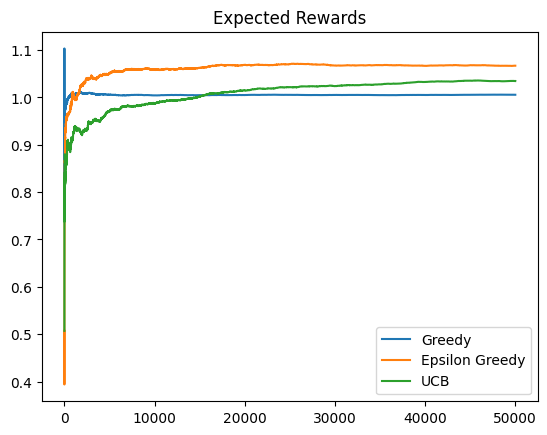

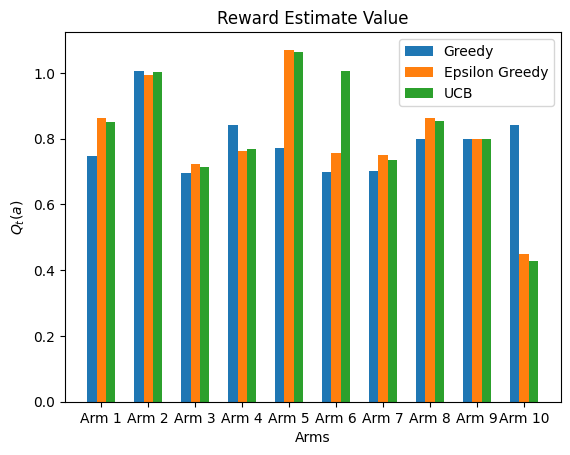

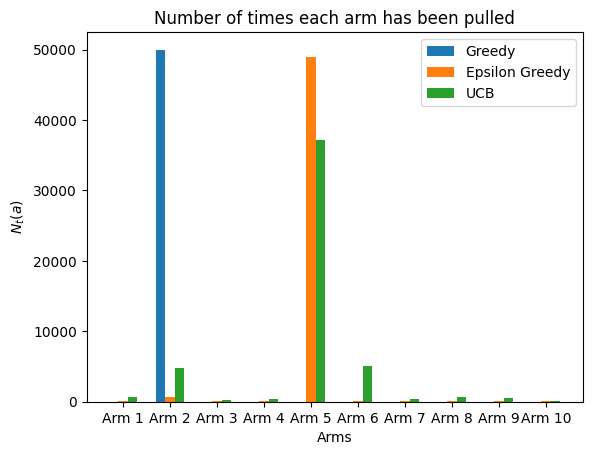

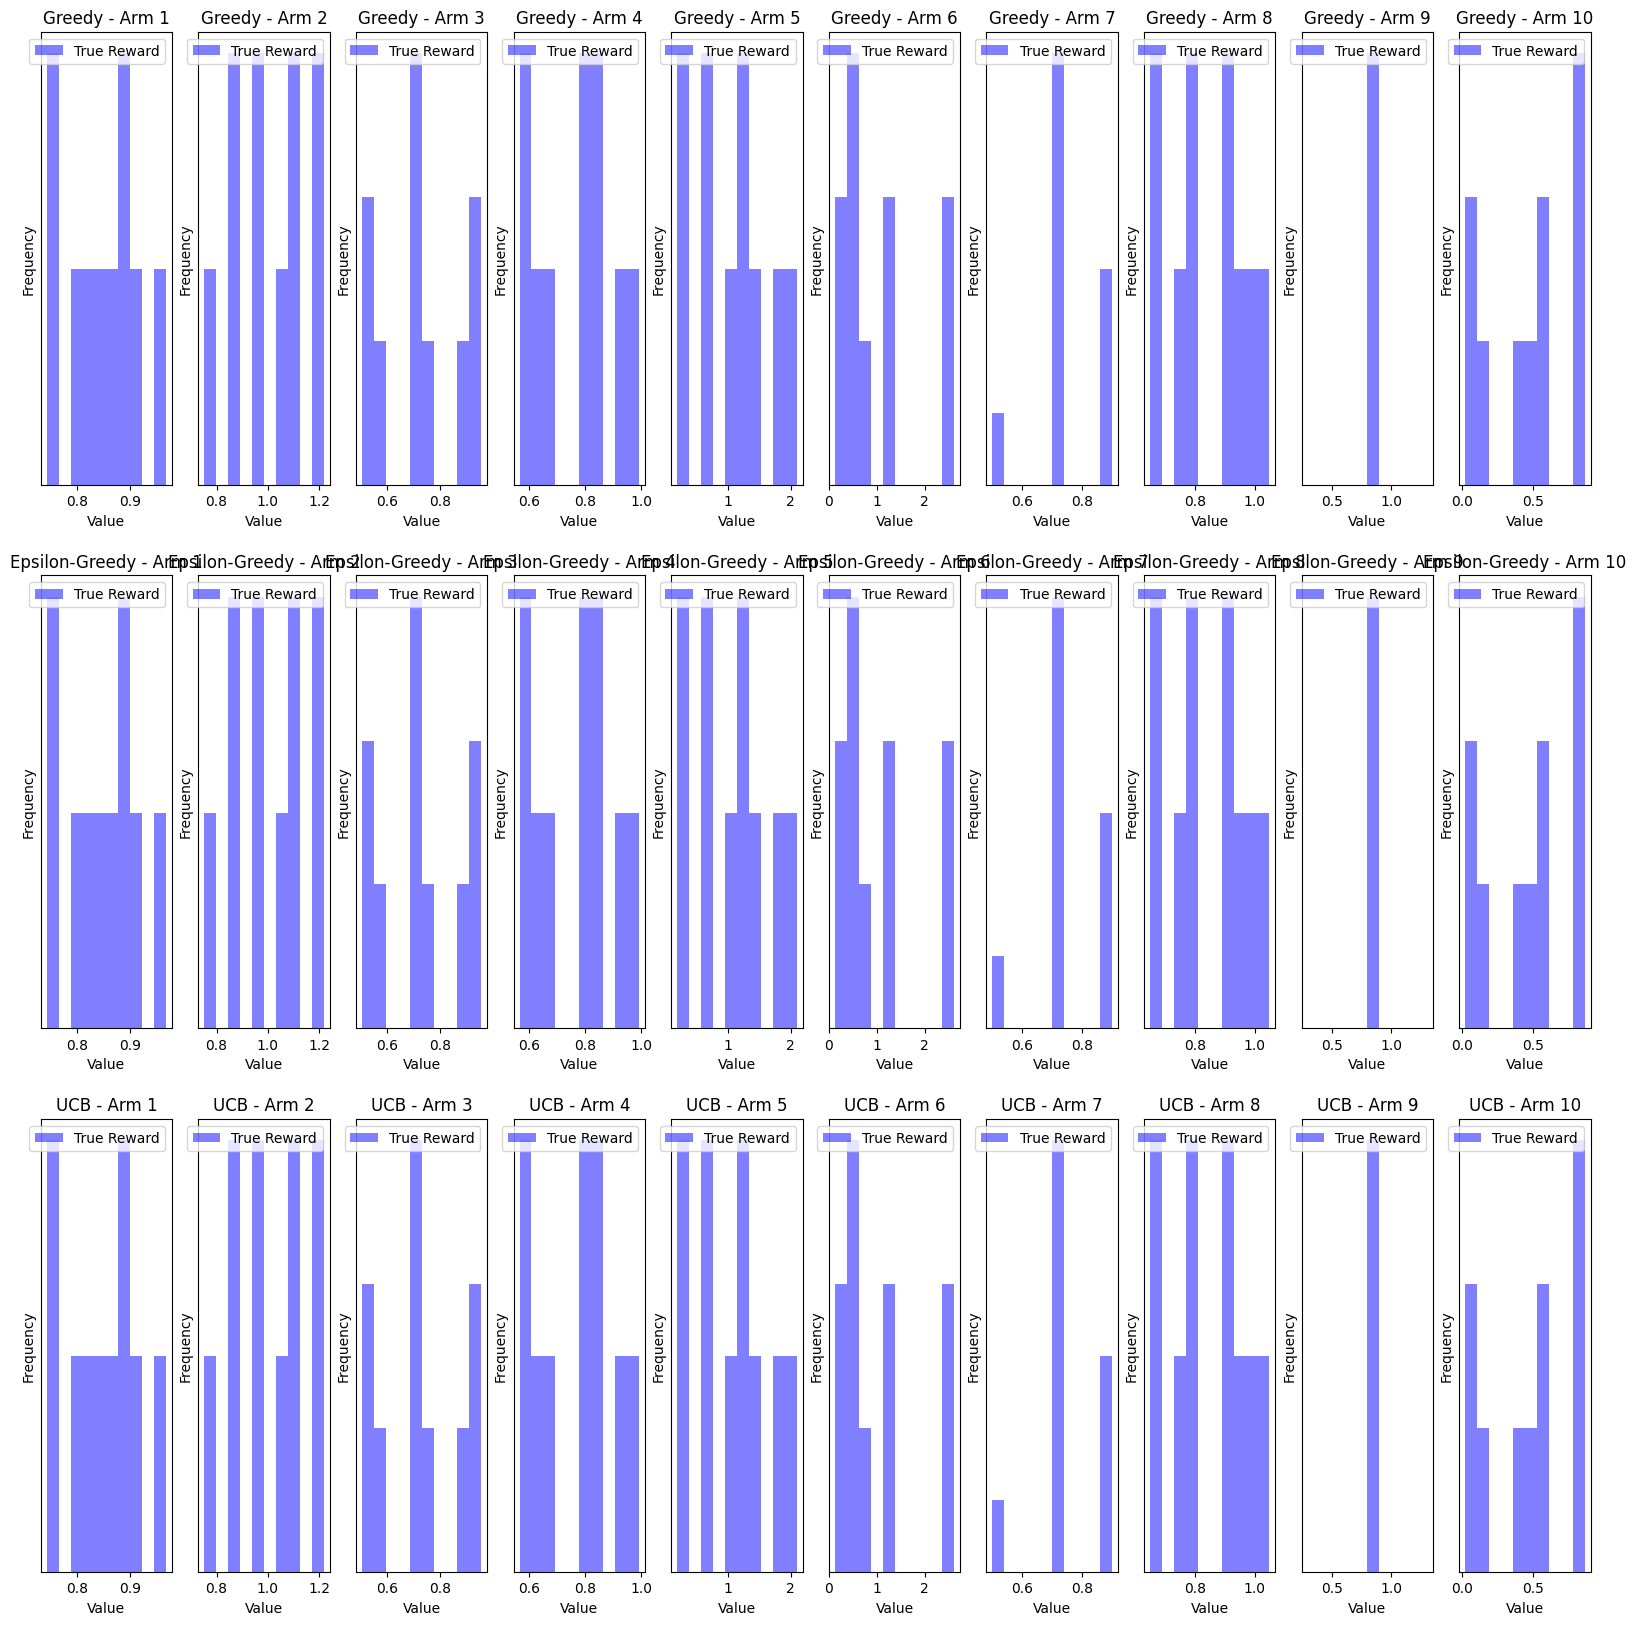

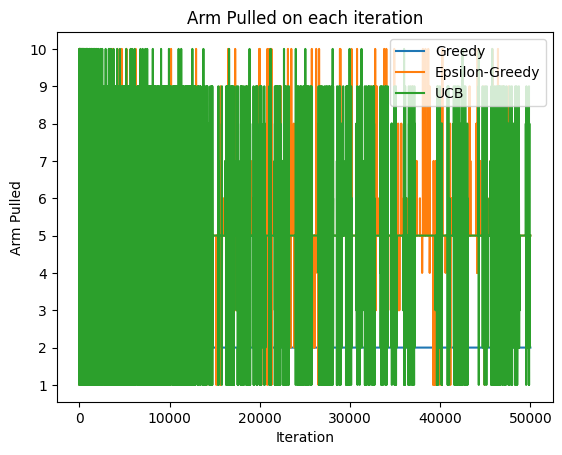

In [64]:
# NOTE: Reset algorithms
greedy_alg.reset()
eps_greedy_alg.reset()
ucb_alg.reset()
# NOTE: Since this is in place, the algorithms will get updated dynamically!
run_multi_armed_bandits(**kwargs)

# Questions

1. What do you notice about $N_{t}\left(a\right)$ for the respective algorithms? Do any of them look similar or different?
2. What do you notice about $Q_{t}\left(a\right)$ for the respective algorithms? Do any of them look similar or different?
3. What happens if you change the $number\_of\_arms$?
4. What happens if you change the $epsilon$ value in Epsilon-Greedy?
5. What happens if you change the $multiplier$ value in UCB?
6. What happens if you change the $num\_iter$?
7. What happens if you make sure that it does not matter if all arms are pulled at least once first?
8. What happens if you change the types of $reward\_dist$?
9. What happens if the distribution of rewards became non-stationary i.e. changed after every pull?

# Final Remarks

Thank you for reading this notebook. Note that there are other implementations of recurrent neural networks (which I would advise you to take a look at to see any differences of similarities with this version).
If there are any mistakes or things that need more clarity, feel free to respond and I will be happy to reply 😊.

© *PolyNath 2023*